# Knowledge Distillation with TensorFlow
By **Marcelo Rovai** @ 01June25
- With support of **Perplexity Labs** and **Claude Sonnet 3.7**

## Implementation with TensorFlow and MNIST

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import time

## Dataset

### Dataset Overview

MNIST is an ideal dataset for learning knowledge distillation:

- **60,000 training images** of handwritten digits (0-9)
- **10,000 test images**
- **28x28 grayscale images**
- **10 classes** (digits 0-9)
- **Well-established baseline performances**

In [2]:
# Load and preprocess data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Dataset Exploration

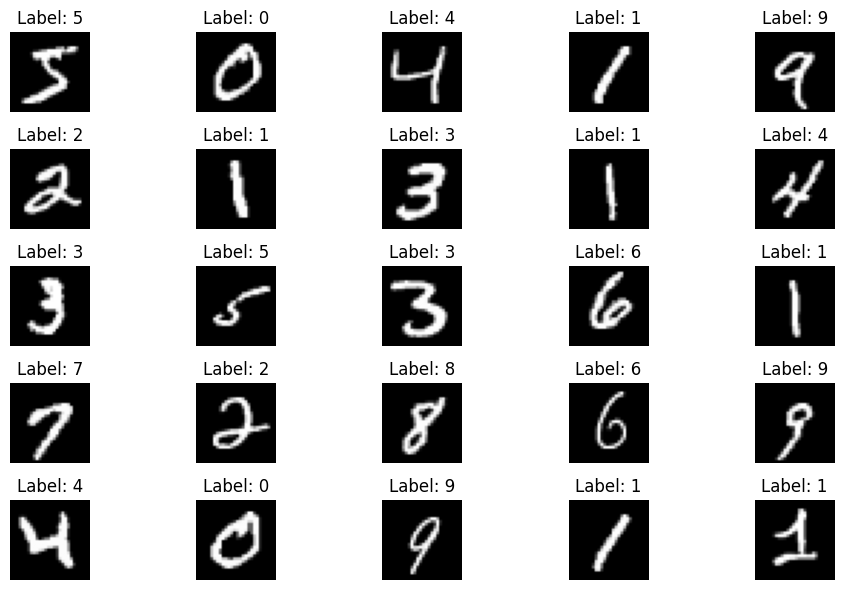

In [3]:
plt.figure(figsize=(10, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Data Convertion & Split

In [4]:
# Convert labels to one-hot encoding for better distillation
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
# Split data
val_split = 0.2
split_idx = int(len(x_train) * (1 - val_split))
x_train_split = x_train[:split_idx]
x_val = x_train[split_idx:]
y_train_split = y_train_one_hot[:split_idx]
y_val = y_train_one_hot[split_idx:]

print(f"Training set: {x_train_split.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")

Training set: (48000, 28, 28, 1)
Validation set: (12000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


## Teacher Model Architecture

The teacher model should be complex enough to achieve high performance:




In [6]:
def build_teacher_model():
    model = models.Sequential([
        layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),

        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [7]:
teacher = build_teacher_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

teacher.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,250 (2.51 MB)

 Trainable params: 656,202 (2.50 MB)

 Non-trainable params: 2,048 (8.00 KB)

## Train the Teacher Model

In [11]:
# Use callbacks to ensure we get the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]

In [12]:
teacher_history = teacher.fit(
    x_train_split, y_train_split,
    validation_data=(x_val, y_val),
    epochs=20,  # More epochs for better performance
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.8096 - loss: 0.6274 - val_accuracy: 0.1100 - val_loss: 6.4001 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9764 - loss: 0.0781 - val_accuracy: 0.9836 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9847 - loss: 0.0527 - val_accuracy: 0.9859 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9882 - loss: 0.0385 - val_accuracy: 0.9845 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9889 - loss: 0.0384 - val_accuracy: 0.9914 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9910 - loss: 0.0292 - val_accuracy: 0.9844 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9929 - loss:

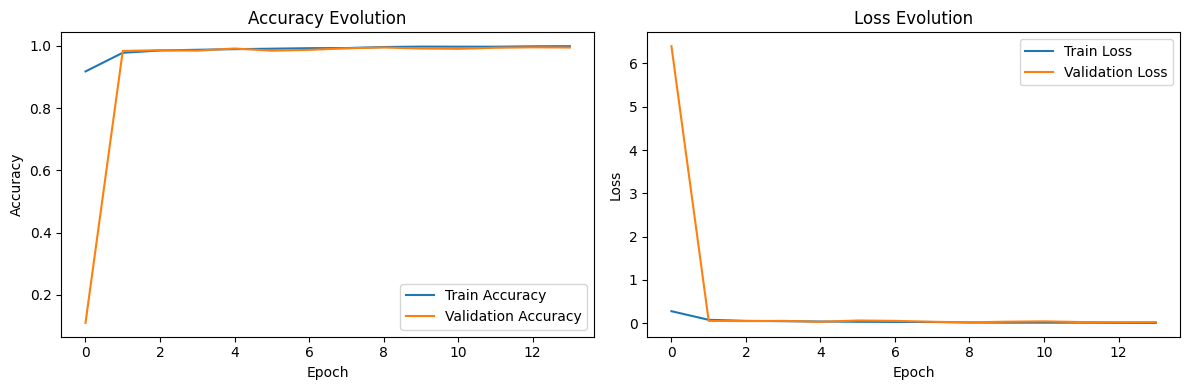

In [13]:
# Plot accuracy and loss curves

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(teacher_history.history['accuracy'], label='Train Accuracy')
plt.plot(teacher_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(teacher_history.history['loss'], label='Train Loss')
plt.plot(teacher_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation


In [14]:
# Evaluate teacher
teacher_loss, teacher_acc = teacher.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Teacher model accuracy: {teacher_acc*100:.2f}%")

Teacher model accuracy: 99.44%


## Student Model

In [15]:
# Student model - smaller than teacher
def build_student_model():
    model = models.Sequential([
        layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [16]:
# Build vanilla student model (for comparison)
vanilla_student = build_student_model()
vanilla_student.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
vanilla_student.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,866 (413.54 KB)

 Trainable params: 105,866 (413.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train vanilla student
vanilla_history = vanilla_student.fit(
    x_train_split, y_train_split,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=128,
    verbose=1
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7989 - loss: 0.7065 - val_accuracy: 0.9700 - val_loss: 0.0988
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9698 - loss: 0.0978 - val_accuracy: 0.9803 - val_loss: 0.0678
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9815 - loss: 0.0611 - val_accuracy: 0.9830 - val_loss: 0.0570
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9849 - loss: 0.0489 - val_accuracy: 0.9839 - val_loss: 0.0533
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9876 - loss: 0.0389 - val_accuracy: 0.9844 - val_loss: 0.0553
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9896 - loss: 0.0335 - val_accuracy: 0.9867 - val_loss: 0.0446
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9926 - loss: 0.0237 - val_accuracy: 0.9868 - val_loss: 0.0455
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9932 - loss: 0.0213 - val_accuracy: 0.

In [19]:
# Evaluate vanilla student
vanilla_loss, vanilla_acc = vanilla_student.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Vanilla student accuracy: {vanilla_acc*100:.2f}%")

Vanilla student accuracy: 98.77%


## Knowledge Distillation implementation

First, generate soft targets from teacher

In [20]:
# Temperature parameter
temperature = 5.0 # Higher temperature for more softening

# Alpha parameter (weight between hard and soft targets)
alpha = 0.3  # More weight on soft targets to benefit from teacher's knowledge

# Get teacher predictions on training and validation data
print("Generating soft targets from teacher...")
teacher_preds_train = teacher.predict(x_train_split, verbose=0)
teacher_preds_val = teacher.predict(x_val, verbose=0)

Generating soft targets from teacher...


Apply temperature to soften the probability distributions

In [21]:
# Apply temperature scaling
def apply_temperature(probs, temperature):
    # Convert to logits
    logits = np.log(probs + 1e-10)
    # Apply temperature
    logits_t = logits / temperature
    # Convert back to probabilities
    probs_t = np.exp(logits_t) / np.sum(np.exp(logits_t), axis=1, keepdims=True)
    return probs_t

In [22]:
# Soften the teacher's predictions
soft_targets_train = apply_temperature(teacher_preds_train, temperature)
soft_targets_val = apply_temperature(teacher_preds_val, temperature)

### Create distillation student model

In [23]:
kd_student = build_student_model()

In [25]:
# Compile with distillation loss
kd_student.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
kd_student.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,866 (413.54 KB)

 Trainable params: 105,866 (413.54 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Custom training loop for knowledge distillation
epochs = 15  # More epochs for better knowledge transfer
batch_size = 128
steps_per_epoch = len(x_train_split) // batch_size
validation_steps = max(1, len(x_val) // batch_size)

In [28]:
# Initialize history dictionary
kd_history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

In [29]:
print("Training student with knowledge distillation...")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training
    train_loss = 0
    train_acc = 0

    # Shuffle training data
    indices = np.random.permutation(len(x_train_split))
    x_shuffled = x_train_split[indices]
    y_hard_shuffled = y_train_split[indices]
    y_soft_shuffled = soft_targets_train[indices]

    for step in range(steps_per_epoch):
        # Get batch
        start_idx = step * batch_size
        end_idx = min(start_idx + batch_size, len(x_shuffled))
        x_batch = x_shuffled[start_idx:end_idx]
        y_hard_batch = y_hard_shuffled[start_idx:end_idx]
        y_soft_batch = y_soft_shuffled[start_idx:end_idx]

        # Forward pass
        with tf.GradientTape() as tape:
            predictions = kd_student(x_batch, training=True)

            # Hard target loss (cross-entropy with true labels)
            hard_loss = tf.keras.losses.categorical_crossentropy(y_hard_batch, predictions)

            # Soft target loss (KL divergence with teacher predictions)
            soft_loss = tf.keras.losses.kullback_leibler_divergence(y_soft_batch, predictions)

            # Combined loss with temperature scaling factor for soft loss
            loss = alpha * hard_loss + (1 - alpha) * soft_loss * (temperature ** 2)

        # Compute gradients and update weights
        gradients = tape.gradient(loss, kd_student.trainable_weights)
        kd_student.optimizer.apply_gradients(zip(gradients, kd_student.trainable_weights))

        # Update metrics
        train_loss += tf.reduce_mean(loss)
        train_acc += tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y_hard_batch, axis=1), tf.argmax(predictions, axis=1)),
            tf.float32))

    # Average training metrics
    train_loss /= steps_per_epoch
    train_acc /= steps_per_epoch

    # Validation
    val_loss = 0
    val_acc = 0

    for step in range(validation_steps):
        # Get batch
        start_idx = step * batch_size
        end_idx = min(start_idx + batch_size, len(x_val))
        x_val_batch = x_val[start_idx:end_idx]
        y_val_hard_batch = y_val[start_idx:end_idx]
        y_val_soft_batch = soft_targets_val[start_idx:end_idx]

        # Forward pass (no training)
        predictions = kd_student(x_val_batch, training=False)

        # Calculate losses
        hard_loss = tf.keras.losses.categorical_crossentropy(y_val_hard_batch, predictions)
        soft_loss = tf.keras.losses.kullback_leibler_divergence(y_val_soft_batch, predictions)
        loss = alpha * hard_loss + (1 - alpha) * soft_loss * (temperature ** 2)

        # Update metrics
        val_loss += tf.reduce_mean(loss)
        val_acc += tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y_val_hard_batch, axis=1), tf.argmax(predictions, axis=1)),
            tf.float32))

    # Average validation metrics
    val_loss /= validation_steps
    val_acc /= validation_steps

    # Update history
    kd_history['loss'].append(float(train_loss))
    kd_history['accuracy'].append(float(train_acc))
    kd_history['val_loss'].append(float(val_loss))
    kd_history['val_accuracy'].append(float(val_acc))

    # Print epoch results
    print(f"loss: {float(train_loss):.4f} - accuracy: {float(train_acc):.4f} - val_loss: {float(val_loss):.4f} - val_accuracy: {float(val_acc):.4f}")


Training student with knowledge distillation...
Epoch 1/15
loss: 2.4718 - accuracy: 0.9277 - val_loss: 0.9380 - val_accuracy: 0.9770
Epoch 2/15
loss: 0.8138 - accuracy: 0.9803 - val_loss: 0.6556 - val_accuracy: 0.9846
Epoch 3/15
loss: 0.6207 - accuracy: 0.9865 - val_loss: 0.5435 - val_accuracy: 0.9876
Epoch 4/15
loss: 0.5266 - accuracy: 0.9885 - val_loss: 0.4705 - val_accuracy: 0.9889
Epoch 5/15
loss: 0.4651 - accuracy: 0.9905 - val_loss: 0.4309 - val_accuracy: 0.9905
Epoch 6/15
loss: 0.4197 - accuracy: 0.9918 - val_loss: 0.4020 - val_accuracy: 0.9913
Epoch 7/15
loss: 0.3875 - accuracy: 0.9925 - val_loss: 0.3899 - val_accuracy: 0.9920
Epoch 8/15
loss: 0.3605 - accuracy: 0.9931 - val_loss: 0.3770 - val_accuracy: 0.9916
Epoch 9/15
loss: 0.3461 - accuracy: 0.9936 - val_loss: 0.3430 - val_accuracy: 0.9923
Epoch 10/15
loss: 0.3263 - accuracy: 0.9941 - val_loss: 0.3337 - val_accuracy: 0.9926
Epoch 11/15
loss: 0.3164 - accuracy: 0.9943 - val_loss: 0.3367 - val_accuracy: 0.9928
Epoch 12/15
los

In [30]:
# Evaluate KD student
kd_loss, kd_acc = kd_student.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Knowledge distilled student accuracy: {kd_acc*100:.2f}%")

Knowledge distilled student accuracy: 99.32%


## Comparative Evaluation

In [31]:
# Print final comparison
print("\nFinal Test Accuracy Comparison:")
print(f"Teacher model:              {teacher_acc*100:.2f}%")
print(f"Student with KD:            {kd_acc*100:.2f}%")
print(f"Student without KD:         {vanilla_acc*100:.2f}%")
print(f"KD Improvement:             {(kd_acc - vanilla_acc)*100:.2f}%")


Final Test Accuracy Comparison:
Teacher model:              99.44%
Student with KD:            99.32%
Student without KD:         98.77%
KD Improvement:             0.55%


In [32]:
print("\nMeasuring inference speed and model size...")

# Calculate inference time
def measure_inference_time(model, x_data, batch_size=128, num_runs=5):
    # Warm-up run
    _ = model.predict(x_data[:batch_size], verbose=0)

    # Timed runs
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = model.predict(x_data, batch_size=batch_size, verbose=0)
        times.append(time.time() - start_time)

    return sum(times) / len(times)  # Average time

# Measure inference times
teacher_time = measure_inference_time(teacher, x_test)
kd_time = measure_inference_time(kd_student, x_test)
vanilla_time = measure_inference_time(vanilla_student, x_test)

print(f"Teacher inference time:     {teacher_time:.4f} seconds")
print(f"Student with KD time:       {kd_time:.4f} seconds")
print(f"Student without KD time:    {vanilla_time:.4f} seconds")
print(f"Speed improvement:          {(teacher_time/kd_time):.2f}x faster than teacher")



Measuring inference speed and model size...
Teacher inference time:     0.8632 seconds
Student with KD time:       0.5467 seconds
Student without KD time:    0.3579 seconds
Speed improvement:          1.58x faster than teacher


In [33]:
# Compare model sizes
teacher_params = teacher.count_params()
kd_params = kd_student.count_params()
vanilla_params = vanilla_student.count_params()

print("\nModel Size Comparison:")
print(f"Teacher parameters:         {teacher_params:,}")
print(f"Student parameters:         {kd_params:,}")
print(f"Size reduction:             {(teacher_params/kd_params):.2f}x smaller than teacher")
print(f"Parameter ratio:            1:{(teacher_params/kd_params):.1f}")



Model Size Comparison:
Teacher parameters:         658,250
Student parameters:         105,866
Size reduction:             6.22x smaller than teacher
Parameter ratio:            1:6.2


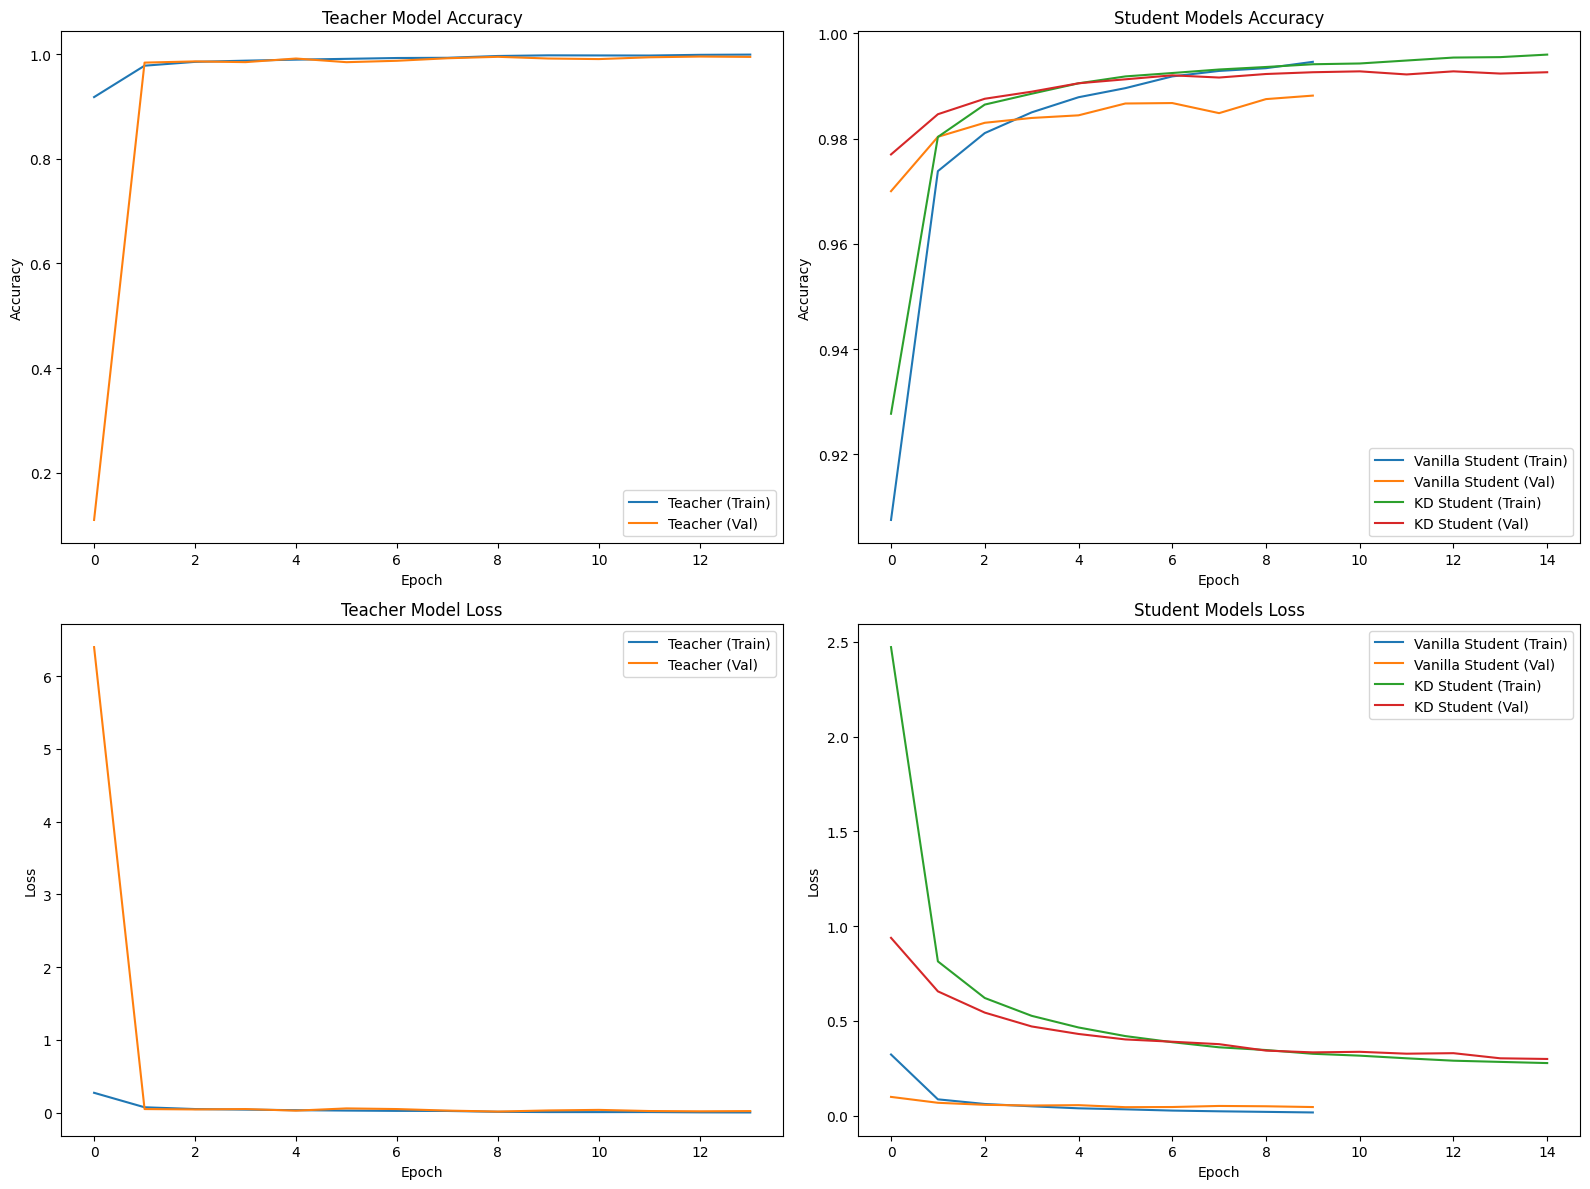

In [34]:
# Visualize results
plt.figure(figsize=(16, 12))

# Training accuracy
plt.subplot(2, 2, 1)
plt.plot(teacher_history.history['accuracy'], label='Teacher (Train)')
plt.plot(teacher_history.history['val_accuracy'], label='Teacher (Val)')
plt.title('Teacher Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Student accuracy comparison
plt.subplot(2, 2, 2)
plt.plot(vanilla_history.history['accuracy'], label='Vanilla Student (Train)')
plt.plot(vanilla_history.history['val_accuracy'], label='Vanilla Student (Val)')
plt.plot(kd_history['accuracy'], label='KD Student (Train)')
plt.plot(kd_history['val_accuracy'], label='KD Student (Val)')
plt.title('Student Models Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training loss
plt.subplot(2, 2, 3)
plt.plot(teacher_history.history['loss'], label='Teacher (Train)')
plt.plot(teacher_history.history['val_loss'], label='Teacher (Val)')
plt.title('Teacher Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Student loss comparison
plt.subplot(2, 2, 4)
plt.plot(vanilla_history.history['loss'], label='Vanilla Student (Train)')
plt.plot(vanilla_history.history['val_loss'], label='Vanilla Student (Val)')
plt.plot(kd_history['loss'], label='KD Student (Train)')
plt.plot(kd_history['val_loss'], label='KD Student (Val)')
plt.title('Student Models Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('kd_comparison_results.png')
plt.show()

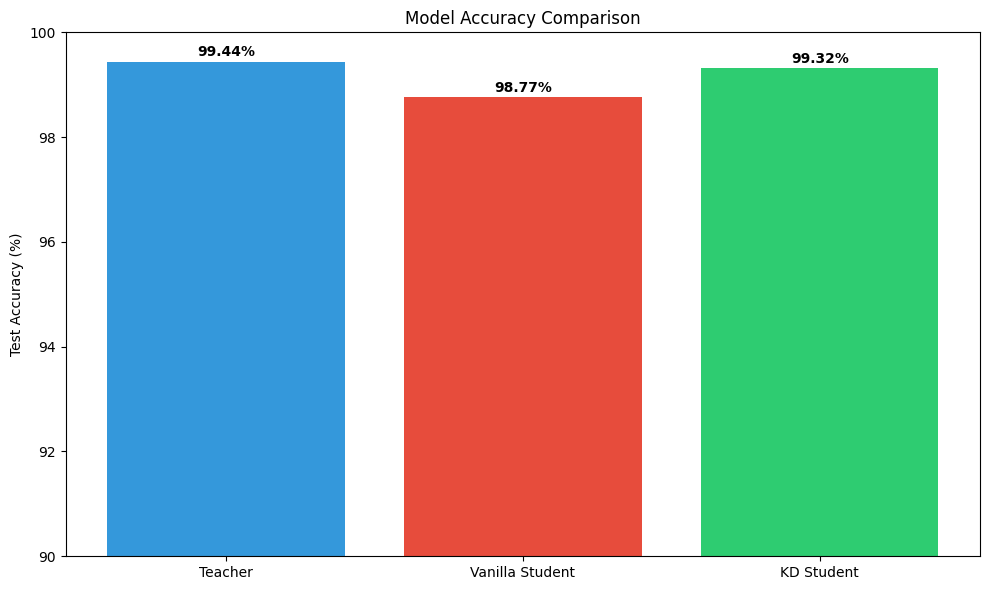

In [35]:
# Create a bar chart comparing accuracies
plt.figure(figsize=(10, 6))
models = ['Teacher', 'Vanilla Student', 'KD Student']
accuracies = [teacher_acc*100, vanilla_acc*100, kd_acc*100]
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Plot bars
bars = plt.bar(models, accuracies, color=colors)
plt.ylabel('Test Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(90, 100)  # Focus on the relevant range for MNIST

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{acc:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()


In [36]:
# Visualize predictions on test examples
def plot_predictions(teacher_model, kd_model, vanilla_model, x_samples, y_true, num_samples=5):
    plt.figure(figsize=(15, 12))

    for i in range(num_samples):
        # Get a sample
        img = x_samples[i:i+1]
        true_label = np.argmax(y_true[i])

        # Get predictions
        teacher_pred = teacher_model.predict(img, verbose=0)
        kd_pred = kd_model.predict(img, verbose=0)
        vanilla_pred = vanilla_model.predict(img, verbose=0)

        # Get predicted classes
        teacher_class = np.argmax(teacher_pred)
        kd_class = np.argmax(kd_pred)
        vanilla_class = np.argmax(vanilla_pred)

        # Plot the image
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.title(f"True: {true_label}")
        plt.axis('off')

        # Plot teacher predictions
        plt.subplot(num_samples, 4, i*4+2)
        plt.bar(range(10), teacher_pred[0])
        plt.title(f"Teacher: {teacher_class}")
        plt.ylim(0, 1)

        # Plot KD student predictions
        plt.subplot(num_samples, 4, i*4+3)
        plt.bar(range(10), kd_pred[0])
        plt.title(f"KD Student: {kd_class}")
        plt.ylim(0, 1)

        # Plot vanilla student predictions
        plt.subplot(num_samples, 4, i*4+4)
        plt.bar(range(10), vanilla_pred[0])
        plt.title(f"Vanilla Student: {vanilla_class}")
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig('prediction_comparison.png')
    plt.show()

In [37]:
# Get some challenging test samples (not just random ones)
def find_challenging_samples(teacher, vanilla_student, x_test, y_test, n_samples=5):
    # Get predictions
    teacher_preds = teacher.predict(x_test, verbose=0)
    vanilla_preds = vanilla_student.predict(x_test, verbose=0)

    # Find samples where teacher is correct but vanilla student is wrong
    teacher_correct = np.argmax(teacher_preds, axis=1) == np.argmax(y_test, axis=1)
    vanilla_correct = np.argmax(vanilla_preds, axis=1) == np.argmax(y_test, axis=1)

    # Get indices where teacher is correct but vanilla student is wrong
    interesting_indices = np.where(np.logical_and(teacher_correct, np.logical_not(vanilla_correct)))[0]

    # If we don't have enough interesting samples, add some random ones
    if len(interesting_indices) < n_samples:
        random_indices = np.random.choice(
            np.setdiff1d(np.arange(len(x_test)), interesting_indices),
            n_samples - len(interesting_indices),
            replace=False
        )
        selected_indices = np.concatenate([interesting_indices, random_indices])
    else:
        # Take a random subset of the interesting indices
        selected_indices = np.random.choice(interesting_indices, n_samples, replace=False)

    return selected_indices

Finding challenging test samples for visualization...


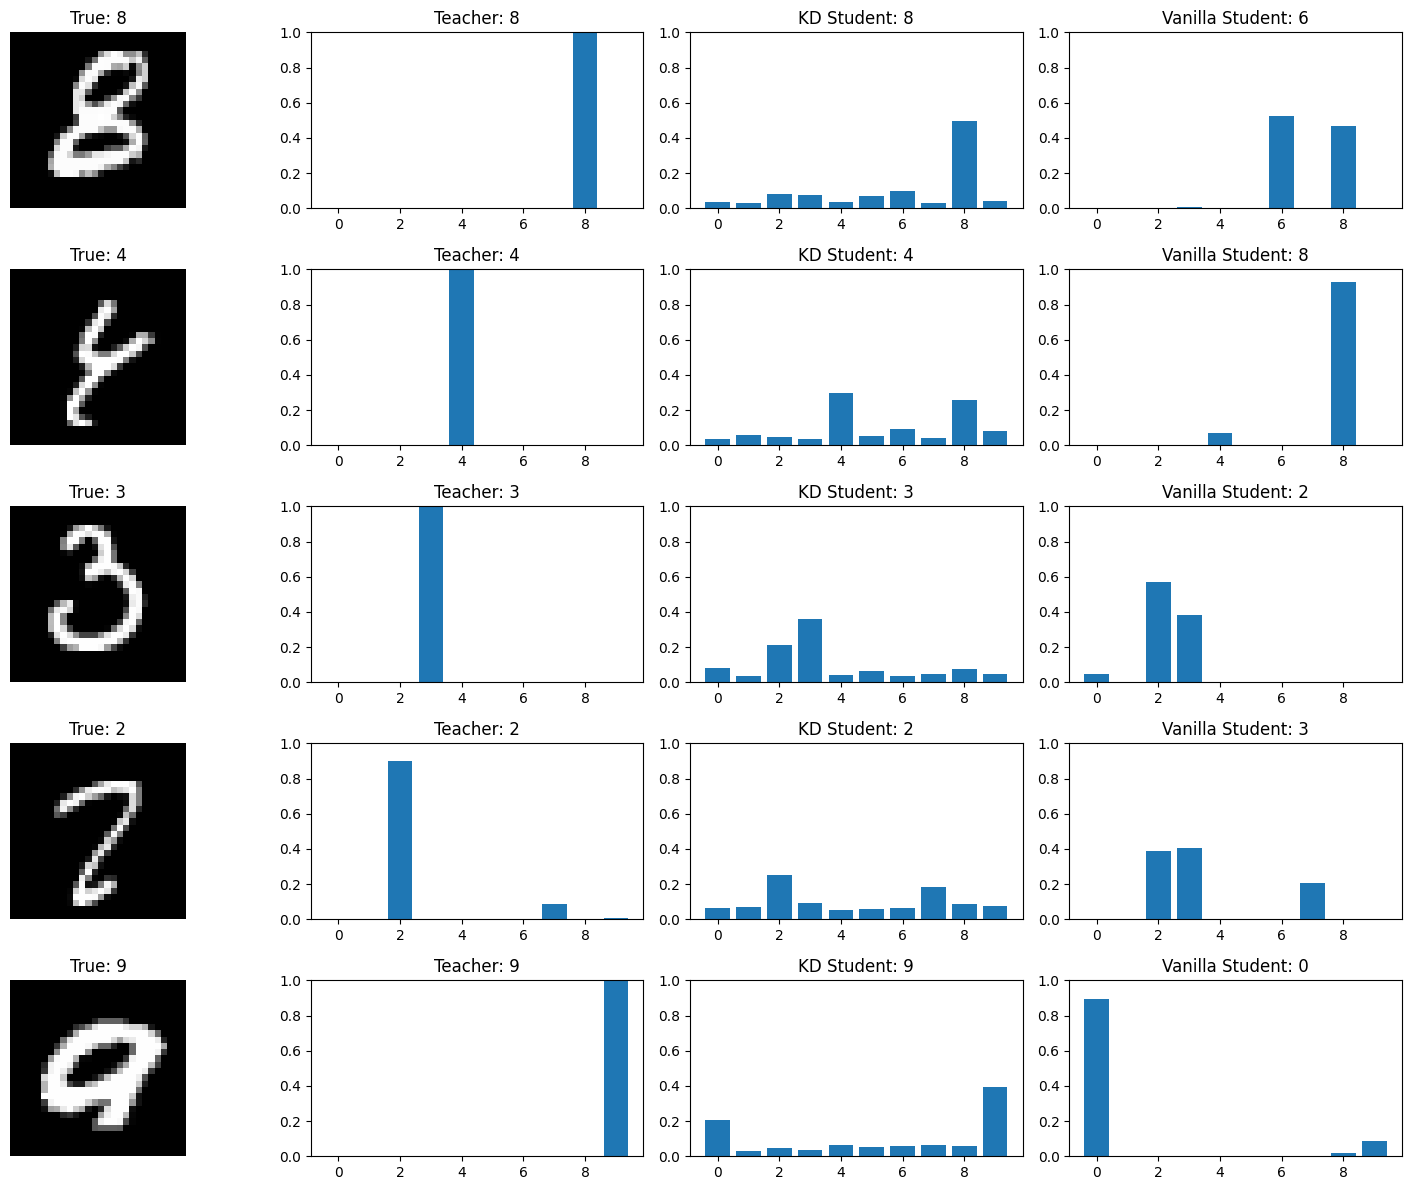

In [38]:
# Find challenging samples
print("Finding challenging test samples for visualization...")
test_indices = find_challenging_samples(teacher, vanilla_student, x_test, y_test_one_hot)
test_samples = x_test[test_indices]
test_labels = y_test_one_hot[test_indices]

# Plot predictions
plot_predictions(teacher, kd_student, vanilla_student, test_samples, test_labels)